In [ ]:
!pip3 install torchvision

In [ ]:
import torch

In [ ]:
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])



transform= transforms.Compose([transforms.Resize([32, 32])
                               , transforms.ToTensor() , # transfor the numpy array to a float tensor
                               transforms.Normalize((0.5,), (0.5,) )])
                               # normalizes the tensor image with mean and standard deviation in the range -1, 1 from 0,1 
                               # nomralization helps reduce Skewness and distortions within out data ensuring a more effective learning process
training_dataset = datasets.CIFAR10(root= './data',train=True, download=True, transform= transform_train )
validation_dataset = datasets.CIFAR10(root= './data', 
                                  train=False, download=True, transform= transform )


Files already downloaded and verified
Files already downloaded and verified


## Training Loader

In [ ]:
# training_loader = torch.utils.data.DataLoader(training_dataset, batch_size= 100, shuffle = 
#                                             True)

### Plotting the Images

To plot the images, we need to convert the tensors back to Numpy arrays

In [ ]:
def im_convert(tensor):   # to convert the tensor into numpy arrays
  image = tensor.cpu().clone().detach().numpy()
  # tensor.detach() creates a tensor that shares storage with tensor that does not require grad 
  # It detaches the output from the computational graph
  # So no gradient will be backpropagated along this variable
  image = image.transpose(1,2,0)
  # Image is in the form of (1, 28 ,28) that is (channels, width, height)
  # We need to swap axes to convert the arrays into (28,28,1) 
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denormalize
  image = image.clip(0,1) # clip all the values outside(0,1)
  return image

In [ ]:
# dataiter = iter(training_loader)
# images, label = dataiter.next()
# fig = plt.figure(figsize=(25,6))

# for idx in range(20):
#   ax = fig.add_subplot(2, 10, idx+1)
#   plt.imshow(im_convert(images[idx]))
#   ax.set_title(label[idx].item())

## Training Loader

In [ ]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size= 100, shuffle = 
                                            True)

In [ ]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size= 100, shuffle = 
                                            False)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

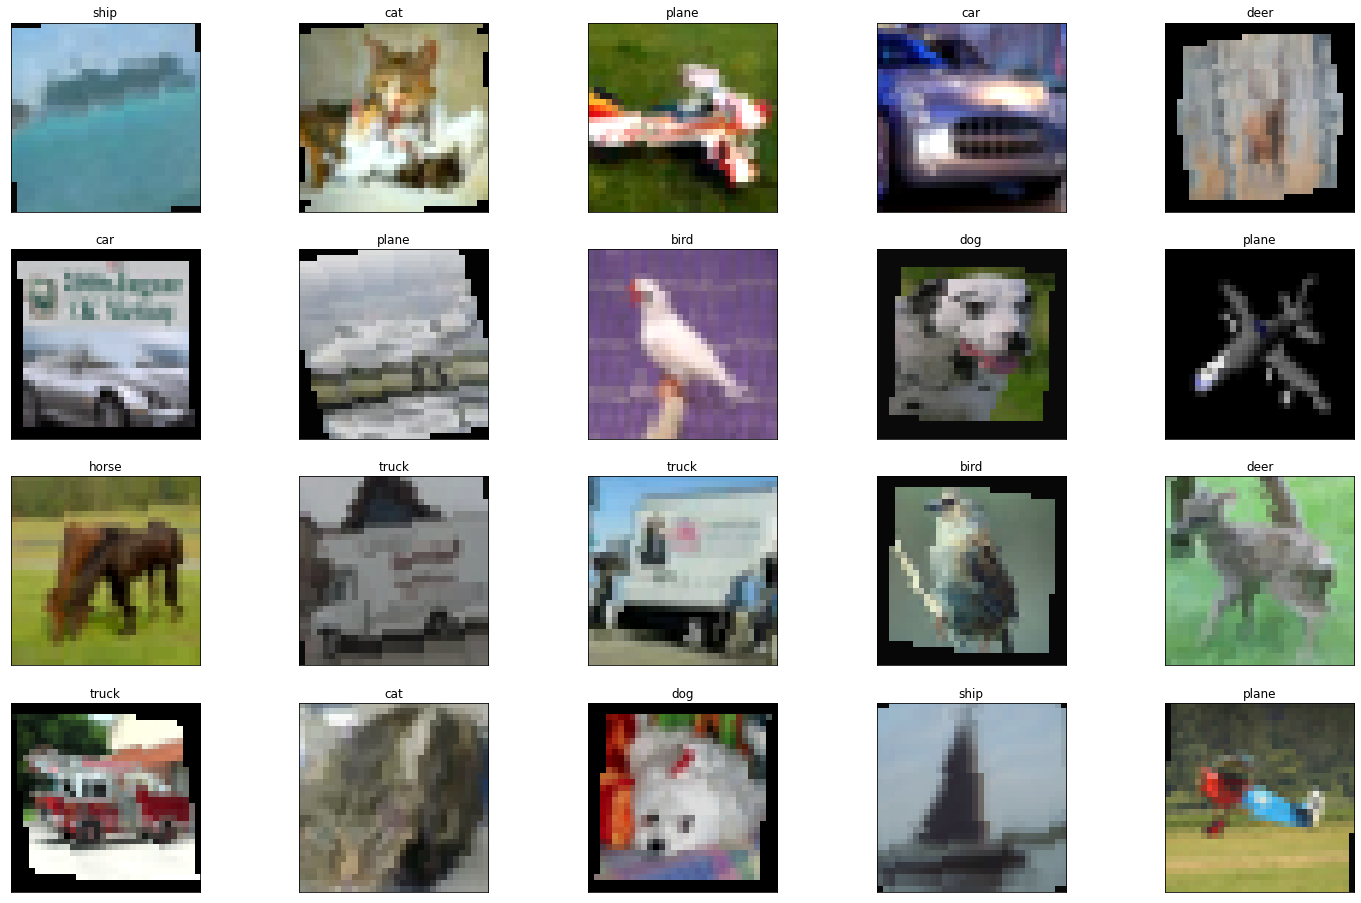

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 16))

for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

### Building the Model

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__() # for provision of various methods and attributes
    """
    Conv2d parameters:
    number of input channels : 1
    number of filters/ output channels : 20
    kernel / filter size : 5
    strides : 1
    """
    """
    Dropout Layers are often added between two layers having highest number of nodes
    In case of this model it is the two linear fully connected layers
    """
    """
    max_pool_2d parameters:
    (feedforward input, kernel_width, kernel_height)
    """ 
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)   
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500) # (number of input channels, number of output channels)   
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10) # (number of input channels, number of output channels)
  def forward(self, x):
    x = F.relu(self.conv1(x))  
    x = F.max_pool2d(x, 2, 2) # cutting the size of the image in half
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2) # cutting the size of the image in half
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64) # reshape the shape into desired output. Similar to .flatten() # x.view() = x.view( number_of_columns, number_of rows)    
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    
    return x

## LeNet Model Architecture

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

## Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss is a combination of log_softmax() and NLLloss()
# Used with classification models with n-classes
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
# ADAM optimizer, most efficient optimizer

In [ ]:
# training_loader

## Training the Model

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # store the tensors in the device(GPU)
    labels = labels.to(device) # store the tensors in the device(GPU)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device) # store the tensors in the device(GPU)
        val_labels = val_labels.to(device) # store the tensors in the device(GPU)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6839, acc 38.6160 
validation loss: 1.4060, validation acc 48.7300 
epoch : 2
training loss: 1.3890, acc 49.9540 
validation loss: 1.2427, validation acc 55.3100 
epoch : 3
training loss: 1.2743, acc 54.4340 
validation loss: 1.1519, validation acc 58.7600 
epoch : 4
training loss: 1.1890, acc 57.6420 
validation loss: 1.1025, validation acc 60.7400 
epoch : 5
training loss: 1.1219, acc 60.0700 
validation loss: 1.0184, validation acc 63.7800 
epoch : 6
training loss: 1.0779, acc 61.8680 
validation loss: 0.9684, validation acc 65.9700 
epoch : 7
training loss: 1.0310, acc 63.5600 
validation loss: 0.9495, validation acc 66.7600 
epoch : 8
training loss: 0.9979, acc 64.8140 
validation loss: 0.9000, validation acc 68.4500 
epoch : 9
training loss: 0.9675, acc 66.2040 
validation loss: 0.9127, validation acc 68.0500 
epoch : 10
training loss: 0.9395, acc 66.9220 
validation loss: 0.8652, validation acc 69.4900 
epoch : 11
training loss: 0.9234, acc 67.5960 
va

## Plotting Training and Validation Losses

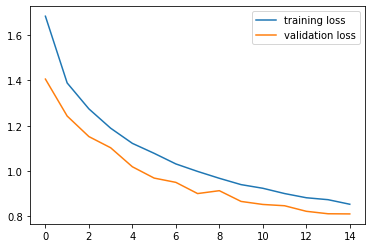

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

## PLotting Training and Validation Accuracies

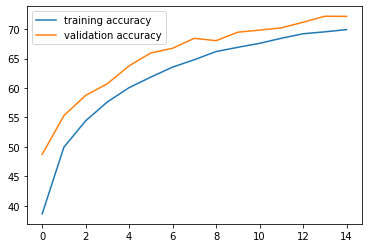

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## Model Testing on Dev Set

In [ ]:
# !pip3 uninstall pillow

In [ ]:
# !pip3 install pillow

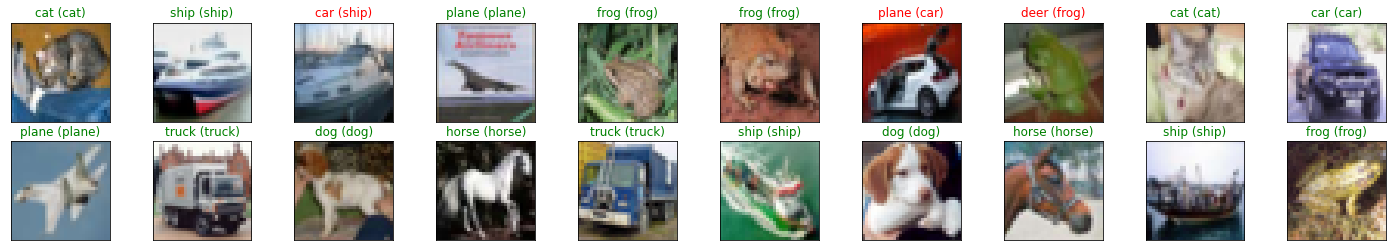

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))


## Validate the model predictions on real life data

In [ ]:
# from google.colab import files
# from io import BytesIO
# from PIL import Image
import PIL.ImageOps
# uploaded = files.upload()
# im = Image.open(BytesIO(uploaded['5.jpg']))

In [ ]:
import PIL
print(PIL.PILLOW_VERSION)

8.2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  


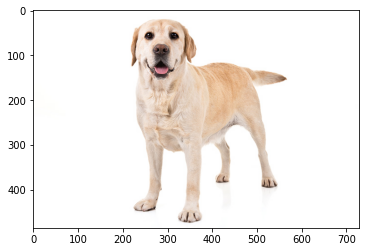

In [ ]:
import requests
from PIL import Image

url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2019/12/03202400/Yellow-Labrador-Retriever.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

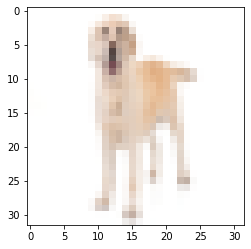

In [ ]:
# img = PIL.ImageOps.invert(img) # no need to invert 
# img = img.convert('1') # no need to conver the image inot bi level format as the model is already trained on 3 channels
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
# image = images[0].unsqueeze(0).unsqueeze(0) # no need to unsqueeze
output = model(image)
_, pred = torch.max(output, 1)
print("The image is of a:",classes[pred.item()])

The image is of a: dog


In [ ]:
output

tensor([[-0.6649, -6.7059,  0.6927,  1.1116, -1.0463,  1.1732, -4.0083,  0.5980,
         -2.3463, -2.8487]], device='cuda:0', grad_fn=<AddmmBackward>)